# Group Invariant Convolutional Network
In this project we will develop a Convolutional Neural Network that is invariant to the actions of a symmetry group. In particular we will consider the cyclic group C4, that includes the four rotation symmetries of a square and the dihedral group D4, that includes all the rotation and reflection symmetries of a square. The Convolutional Neural Network will learn a classification function that should be invariant to the group actions. To test the invariance I trained the network on the famous FashionMNIST dataset and I augmented only the testset by applying at random actions from the chosen group.

## Dihedral Group D4
In this section I will explain the class `DihedralGroup`, that implement the action of the group applied on the R2 grid as well as the composition of group actions.

In [1]:
from PIL import Image
import torch
from torchvision import transforms
from groupconv.groups import *
from groupconv.conv import *
from models.baseline import SimpleCNN
from models.equivariant import EqSimpleCNN
from utils.train import val,count_params
from data.loader import get_loader
import matplotlib.pyplot as plt
import itertools
torch.manual_seed(0)

The class `DihedralGroup` implements the actions of the DihedralGroup, that is the symmetry group of rotations and reflections of a regular polygon with n vertices. For this reason the constructor needs the number of vertices of the polygon. In the network implementation I will restrict to the d4 group (symmetries of a square) in order to not introduce interpolation artifacts. However I implemented the DihedralGroup parametric in the number of vertices, hence the group can be instantiated for any regular polygon, and if the coordinates of the transformed grid do not end up into integer coordinates the resulting pixel is interpolated.

In [2]:
d4 = DihedralGroup(4)
rot0, rot1, rot2, rot3, ref1, ref2, ref3, ref4 = d4.elements()

/home/giorgio/Desktop/GroupEquivariantConvNetworks/DLAI_D4EqConvNet/groupconv/groups.py:203: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  return torch.range(start=0,end=self.order-1,dtype=torch.int32)


In [3]:
img = Image.open("images/bitmap.png").convert('RGB')
img_tensor = transforms.ToTensor()(img)
img_tensor.shape

torch.Size([3, 547, 547])

In [4]:
# This creates a grid of the pixel locations in our image, normalized in the range [-1,1]
img_grid_R2 = torch.stack(torch.meshgrid(
    torch.linspace(-1, 1, img_tensor.shape[-1]),
    torch.linspace(-1, 1, img_tensor.shape[-2]),
))
img_grid_R2.shape

/home/giorgio/.local/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([2, 547, 547])

The method `left_action_on_R2` takes a batch of group actions and a 2D grid and apply each action to the grid.

In [5]:
actions = torch.stack([rot0, rot1, rot2, rot3, ref1, ref2, ref3, ref4],dim=0)
transformed_grid = d4.left_action_on_R2(d4.inverse(actions),img_grid_R2)
transformed_grid.shape

torch.Size([8, 547, 547, 2])

In [6]:
# Given an input and a grid, computes the output using input values and pixel locations from grid.
# Grid and input are expected to have same batch size, hence we repeat the img_tensor for each action
# along the first axis.
img_tensor = img_tensor.unsqueeze(0).repeat(8,1,1,1)
transformed_imgs = torch.nn.functional.grid_sample(img_tensor,transformed_grid,align_corners=True, mode="bilinear")
transformed_imgs.shape

torch.Size([8, 3, 547, 547])

The following figure shows the effects of all the 8 actions on an image. In the first row we see all the rotations, and in particular from left to right:
- 0 degrees (identity)
- 90 degrees counterclockwise
- 180 degrees counterclockwise
- 270 degrees counterclockwise

While on the second row the effects of the reflections are shown. From left to right:
- reflection along vertical axis
- reflection along first diagonal
- reflection along horizontal axis
- reflection along second diagonal

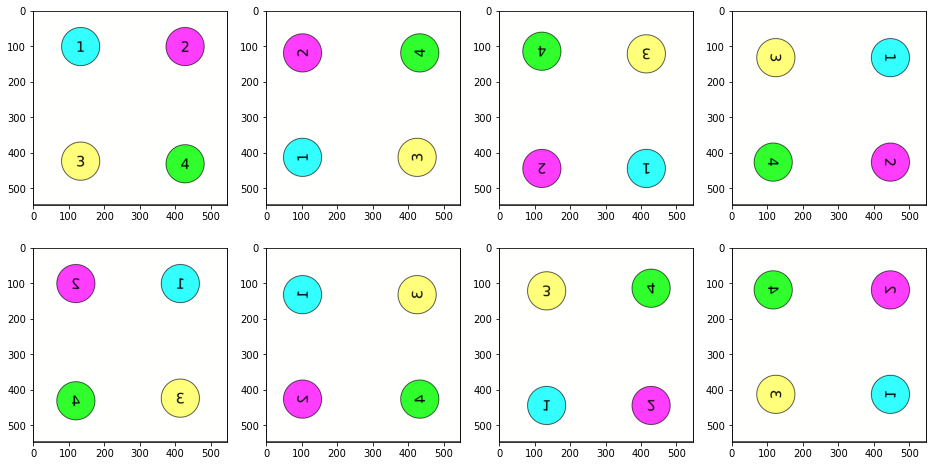

In [7]:
transformed_imgs_chlast = torch.einsum("bchw->bhwc",transformed_imgs)
fig,axes = plt.subplots(2,4)
fig.set_size_inches(16,8)
for i,ax in enumerate(axes.flat):
    ax.imshow(transformed_imgs_chlast[i])
plt.show()


## Group Equivariant Convolution
In this section we will discuss the Group Equivariant Convolution and its implementation.

### From Standard Convolution to Group Equivariant Convolution
Before dealing with the group equivariant convolution lets recall the equation of the standard convolution between the feature map $f:Z^2 \rightarrow R^{K^l}$ and the filters $\psi^i : Z^2 \rightarrow R^{K^l}$:
$$
[f * \psi](x) = \sum_{y\in Z^2}\sum_{k=1}^{K^l}f_k(y)\psi_{k}^i(x-y)
$$
Since we are introducing a convolutional layer that is equivariant to the actions of a more general group, we need to introduce the following notation:
$$
[L_g f](x) = [f \circ g^{-1}](x) = f(g^{-1}x)
$$
As shown in the example above, if we want to rotate the image of 90 degrees counterclockwise we need to rotate the grid clockwise (inverse transform) and then use the transformed grid to lookup in the original image.
In the group equivariant convolution we replace the shift with a more general discrete group G. However we need to distinguish two cases:
- The first convolution convolves the input layer (that is a function of $Z^2$) with the output filters $\psi^i$ (that is also a function of $Z^2$). Note that the output feature map is a function on G (rather than Z^2). The equation is the following:
$$
[f * \psi^i](g) = \sum_{y\in Z^2}\sum_k f_k(y)\psi_{k}^i(g^{-1}y)
$$
- The convolutions after the first one convolve a feature map that is a function on G that is also a function on G:
$$
[f * \psi^i](g) = \sum_{h\in G}\sum_k f_k(h)\psi_{k}^i(g^{-1}h)
$$
In order to leverage the pytorch implementation of the planar convolution we will consider a group that is a split, meaning that its actions $g$ can be decomposed into a translation $t$ and another action $s$ that leaves the origin unchanged, hence $g=ts$. In this case the convolution can be written as:
$$
[f * \psi^i](ts) = \sum_{h\in X}\sum_k f_k(h)L_t[L_s\psi_{k}^i(h)]
$$
Where $X=Z^2$ in the the first convolution and $X=G$ in further convolutions. This formulation allows to use the planar convolution algorithm. In particular we first transformt the filter $\psi$ with the action s and then apply the translation. The outer summation in the further convolution is over the group action. We know that, after the first convolution, the feature maps and the filters are functions over the group, hence they have three cordinates, two for the translation (spatial coordinates) and one for the stabilizer (group actions that leaves the origin unchanged). Let us call $H$ the stabilizer (that in our case is the D4 group). We can reshape the kernel from
- `(in_channels, out_channels, elements_of_H, spatial_dim_1, spatial_dim_2)` 

to

- `(in_channels * elements_of_H, out_channels, spatial_dim_1, spatial_dim_2)` 

and the input from
- `(channels, elements_of_H, spatial_dim_1, spatial_dim_2)` 

to 

- `(channels * elements_of_H, spatial_dim_1, spatial_dim_2)` 

such that the palanar convolution, by summing over the input channels, will sum also over the stabilizer. Then, before computing the convolution, we transform the kernel with all the actions from the stabilizer. The resulting kernel has shape:
- `(in_channels * elements_of_H, elements_of_H, out_channels,spatial_dim_1,spatial_dim_2)`. 

At this point we reshape again the kernel to:
- `(in_channels * elements_of_H,out_channels * elements_of_H, spatial_dim_1, spatial_dim_2)` 

because the output feature map is a function of both t and s, and with the standard planar convolution we get an output for each output channel for each element of H. Then we reshape the output feature map from:
- `(out_channels * elements_of_H, spatial_dim_1, spatial_dim_2)` 

to
- `(out_channels, elements_of_H, spatial_dim_1, spatial_dim_2)`.

#### Lifting Convolution
The first convolution is called "Lifting Convolution" and transform the input feature map, that is a function on $Z^2$ into the output feature map, that is a function on the group G. The equation is:
$$
[f * \psi^i](ts) = \sum_{h\in G}\sum_k f_k(h)L_t[L_s\psi_{k}^i(h)]
$$
In our case the stabilizer is the group D4 ($s\in D4$) that is the groups of symmetries of a square.
In order to take advantage of the pytorch implementation of the convolution we create the kernel weights as a parameter with shape 
- `(out_channels,in_channels,height,width)`. 

Then the method `InterpolativeLiftingKernel.sample()` applies each action of the group D4 to the kernel, such that the new convolutional kernel has shape 
- `(out_channels,n_group_elems,in_channels,height,width)`. 

In order to compute the convolution with the pytorch implementation we reshape the kernel as 
- `(out_channels*n_group_elems,in_channels,height,width)`, 

compute the planar convolution and then reshape the output to 
- `(batch_size,output_channels,n_group_elems,height,width)`. 

Now the output is a function of the group $o[ts]$, where the rotation/reflection index is the second dimension while the spatial indexes are the last two dimensions.

In [8]:
kernel_weights = Image.open("images/bitmap.png").convert('L')
kernel_weights = transforms.ToTensor()(kernel_weights)[0,...]
kernel_weights.shape

torch.Size([547, 547])

In [9]:
lift_conv = LiftingConvolution(group=d4,in_channels=1,out_channels=1,kernel_size=547)
lift_conv.kernel.weight.data = kernel_weights.unsqueeze(0).unsqueeze(0)
lift_conv.kernel.weight.data.shape

torch.Size([1, 1, 547, 547])

In [10]:
kernels = lift_conv.kernel.sample().detach()
kernels.shape

torch.Size([1, 8, 1, 547, 547])

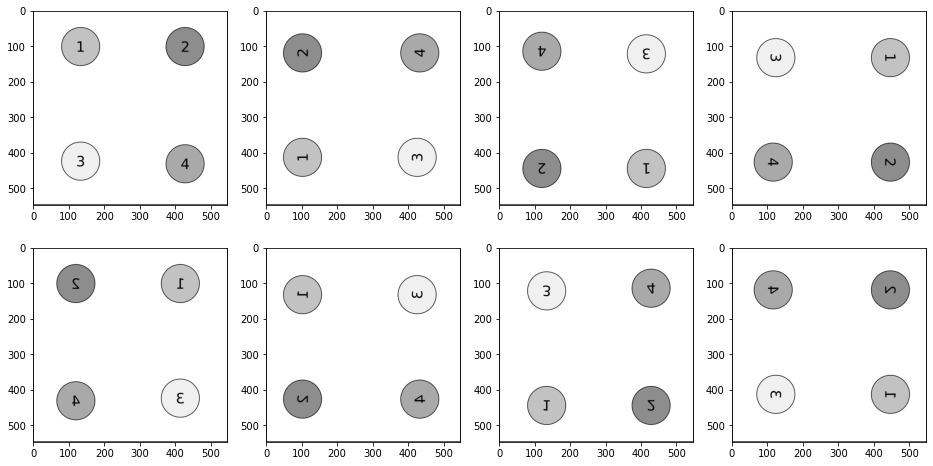

In [11]:
fig,axes = plt.subplots(2,4)
fig.set_size_inches(16,8)
for i,ax in enumerate(axes.flat):
    ax.imshow(kernels[0,i,0,...],cmap="gray")
plt.show()

#### General Convolution
In the further layers the convolution equation becomes
$$
[f * \psi^i](ts) = \sum_{h\in X}\sum_k f_k(h)L_t[L_s\psi_{k}^i(h)]
$$

Here the implementation becomes more tricky because we need to take into account how two group actions compose. This is implemented in the `InterpolativeGroupKernel.sample()` method that transforms the kernel weights (that now are defined over G) with the actions of the group D4. In particular each weight has a spatial coordinate and a D4 group coordinate, and the actions of D4 have an effect on both coordinates. The figure below shows an example of how the kernel weights transform under the D4 group actions. The ith row represents the kernel weights transformed under the ith D4 action. The columns encode the D4 group coordinate while the images show the spatial coordinates.

In [12]:
kernel_size=128
kernel_weights = []
for i in range(8):
    img = Image.open(f"images/{i}.png").convert('L').resize((kernel_size,kernel_size))
    img_tensor = transforms.ToTensor()(img)
    kernel_weights.append(img_tensor)
kernel_weights = torch.stack(kernel_weights,dim=1)
kernel_weights = kernel_weights.unsqueeze(0)
kernel_weights.shape

torch.Size([1, 1, 8, 128, 128])

In [13]:
group_conv = GroupConvolution(group=d4,in_channels=1,out_channels=1,kernel_size=kernel_size)
group_conv.kernel.weight.data = kernel_weights#torch.einsum("abcde->acbde",kernels)#[:,[0],...].repeat(1,8,1,1,1))

In [14]:
kernels = group_conv.kernel.sample().detach()
kernels.shape

torch.Size([1, 8, 1, 8, 128, 128])

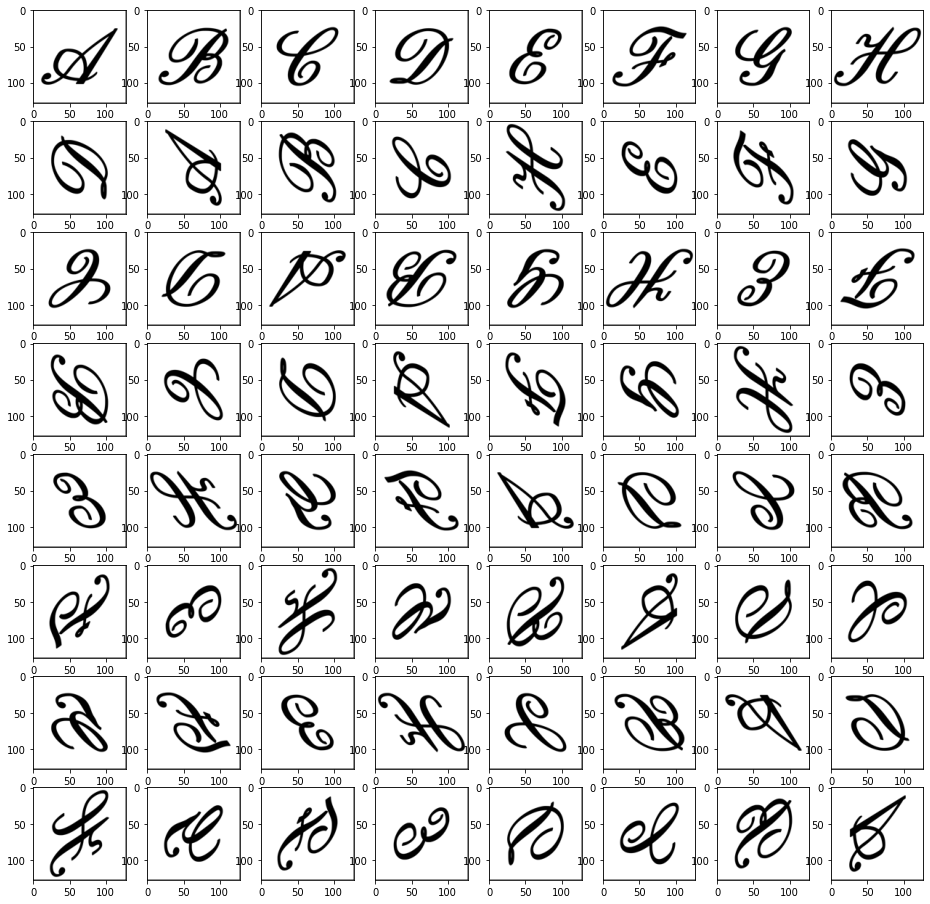

In [15]:
fig,axes = plt.subplots(8,8)
fig.set_size_inches(16,16)
for g_idx in range(8):
    for g_p_idx in range(8):
        axes[g_idx,g_p_idx].imshow(kernels[0,g_idx,0,g_p_idx,...],cmap="gray")
plt.show()

In order to understand how the D4 group coordinate is transformed consider the following composition rule. Considering that the elements of D4 are four rotations $r_0,r_1,r_2,r_3$ and four reflections $s_0,s_1,s_2,s_3$ hence:
- $r_i r_j = r_{i+j \mod 4}$
- $r_i s_j = s_{i+j \mod 4}$
- $s_i r_j = s_{i-j \mod 4}$
- $s_i s_j = r_{i-j \mod 4}$

In [16]:
transformed_elems = d4.left_action_on_H(d4.elements(),d4.elements())
transformed_elems

tensor([[0., 1., 2., 3., 4., 5., 6., 7.],
        [1., 2., 3., 0., 7., 4., 5., 6.],
        [2., 3., 0., 1., 6., 7., 4., 5.],
        [3., 0., 1., 2., 5., 6., 7., 4.],
        [4., 5., 6., 7., 0., 1., 2., 3.],
        [5., 6., 7., 4., 3., 0., 1., 2.],
        [6., 7., 4., 5., 2., 3., 0., 1.],
        [7., 4., 5., 6., 1., 2., 3., 0.]])

## From Equivariance to Invariance

Up to now we implemented a convolutional layer that is equivariant to the actions of the group D4 (without loosing the translation equivariance). This means that computing the convolution and then applying an action from the group D4 is the same as first applying the action to the input and then computing the convolution:
$$
[L_h f * \psi^i](g) = L_h[f * \psi^i](g)
$$
In particular, if the input is transformed by an action of D4 (90 degrees rotations or reflections) then the output is the same, up to a permutation of the feature maps. For example let us consider the example in the figure above. If we apply the filter to the letter A in the normal position, then the top left kernel will produce an high activation, wether if we apply the filter to the letter A reflected on the horizontal axis, then the 7th kernel in the 7th row will produce the same activation.

In standard convolutional networks, translation invariance is obtained with pooling, and most of the times with Max Pooling. The Max Pooling operation (often applied with stride) takes the maximum response over a region of the feature map. With strided Max Pooling the representation becomes invariant to local translations, and stacking Max Pooling layers the representation becomes more and more invariant. For example if we apply strided Max Pooling over a $2\times 2$ region, then, after n Max Pooling layers, a single pixel (with its channels) encodes the information of a $2^n \times 2^n$ patch in the original image.

If the neural network must learn a function that is invariant to translations (like for example a classification function) then we can stack Max Pooling layers untill the feature map is reduced to a single pixel, hence there is no spatial dimension. 

In this project we want to come up with a neural network that is invariant not only to translations, but also to the actions of the Dihedral Group D4 (the group of all the symmetries of a square). As explained in the previous sections, in the group equivariant convolution, with respect to standard convolution, each pixel of the feature map has three dimensions: two spatial dimensions and a group dimension, that defines the orientation of the feature in terms of group actions. So if we take the maximum over the third dimension (max pooling over the group dimension) the representation becomes invariant to the actions of the group. 

Since the Max Pooling operation looses information, we applied the Max Pooling over the group dimension (implemented in `groupconv.conv.GroupMaxPool`) just before the classification layer. In this way the network can create a rich representation that is equivariant to group actions untill the last convolutional layer, and then we get invariance from equivariance in the last layer.

## Results

We tested the group invariant convolutional neural network on the Fashion-MNIST, containing 28x28 grayscale images, associated with a label from 10 classes. In particular, we performed the following experiment:
- Train the Standard convolutional neural network (Standard-CNN) on Fashion-MNIST with no augmentation
- Train the C4 equivariant convolutional network (C4-NN), that is the neural network invariant to the actions of C4 (the group of 90 degrees rotations), on Fashion-MNIST with no augmentation
- Train the D4 equivariant convolutional network (D4-NN), that is the neural network invariant to the actions of D4 (the group of symmetries of a square), on Fashion-MNIST with no augmentation
- Test the three models with three testsets: 1) the testset without augmentation, 2) the testset augmented applying at random the actions of C4, 3) the testset augmented applying at random the actions of D4.

### Standard-CNN

In [17]:
# instantiate the model
N_CLASSES = 10
standard_cnn = SimpleCNN(N_CLASSES)
print(standard_cnn)

SimpleCNN(
  (c1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (r1): ReLU()
  (p1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (r2): ReLU()
  (p2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (r3): ReLU()
  (gp): GlobalMaxPooling()
  (clf): Linear(in_features=256, out_features=10, bias=True)
)


In [18]:
print(f"Number of parameters: {count_params(standard_cnn)}")

Number of parameters: 372234


In [19]:
# load the trained weights
ret = standard_cnn.load_state_dict(torch.load("ckpt/SimpleCNN_FashionMNIST.pth"))
ret

<All keys matched successfully>

#### Testing on testset without augmentation

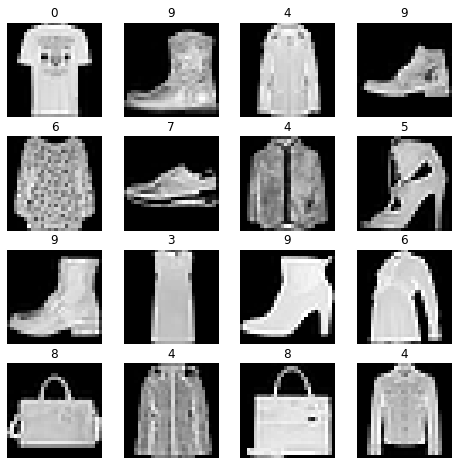

In [20]:
testset = get_loader(split="test",bs=1,nclass=N_CLASSES,augment=None)
top16 = itertools.islice(iter(testset),16)
fig,ax = plt.subplots(4,4)
fig.set_size_inches(8,8)
for i,(x,y) in enumerate(top16):
    ax.flat[i].imshow(x[0,0,...],cmap="gray")
    ax.flat[i].set_title(f"{torch.argmax(y[0]).numpy()}")
    ax.flat[i].axis("off")
plt.show()

In [21]:
acc,loss = val(
    testset,
    standard_cnn.cuda(),
    torch.nn.CrossEntropyLoss(),
    "cuda"
)
print(f"Test Acc:{acc*100:.2f}%     Test Loss:{loss:>7f}")

Test Acc:90.92%     Test Loss:0.387546


#### Testing on testset augmented with actions of C4

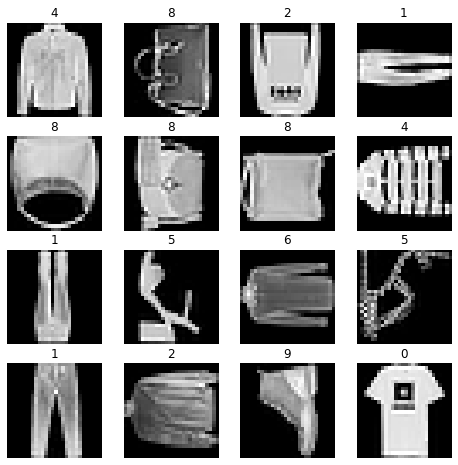

In [22]:
testset = get_loader(split="test",bs=1,nclass=N_CLASSES,augment="c4")
top16 = itertools.islice(iter(testset),16)
fig,ax = plt.subplots(4,4)
fig.set_size_inches(8,8)
for i,(x,y) in enumerate(top16):
    ax.flat[i].imshow(x[0,0,...],cmap="gray")
    ax.flat[i].set_title(f"{torch.argmax(y[0]).numpy()}")
    ax.flat[i].axis("off")
plt.show()

In [23]:
acc,loss = val(
    testset,
    standard_cnn.cuda(),
    torch.nn.CrossEntropyLoss(),
    "cuda"
)
print(f"Test Acc:{acc*100:.2f}%     Test Loss:{loss:>7f}")

Test Acc:32.67%     Test Loss:9.548372


#### Testing on testset augmented with actions of D4

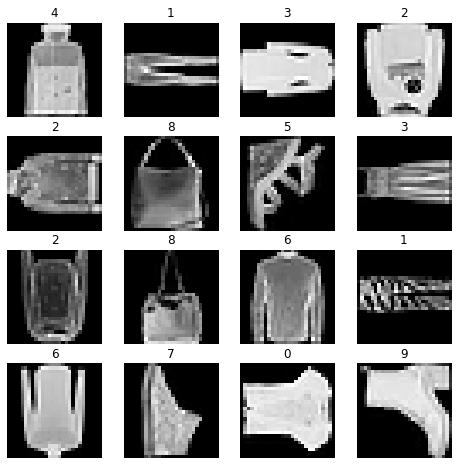

In [24]:
testset = get_loader(split="test",bs=1,nclass=N_CLASSES,augment="d4")
top16 = itertools.islice(iter(testset),16)
fig,ax = plt.subplots(4,4)
fig.set_size_inches(8,8)
for i,(x,y) in enumerate(top16):
    ax.flat[i].imshow(x[0,0,...],cmap="gray")
    ax.flat[i].set_title(f"{torch.argmax(y[0]).numpy()}")
    ax.flat[i].axis("off")
plt.show()

In [25]:
acc,loss = val(
    testset,
    standard_cnn.cuda(),
    torch.nn.CrossEntropyLoss(),
    "cuda"
)
print(f"Test Acc:{acc*100:.2f}%     Test Loss:{loss:>7f}")

Test Acc:32.29%     Test Loss:9.049072


### C4-CNN

In [26]:
# instantiate the model
N_CLASSES = 10
c4_cnn = EqSimpleCNN(CyclicGroup(4),4,N_CLASSES)
print(c4_cnn)

EqSimpleCNN(
  (c1): LiftingConvolution(
    (kernel): InterpolativeLiftingKernel(
      (group): CyclicGroup()
    )
  )
  (r1): ReLU()
  (p1): SpatialMaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c2): GroupConvolution(
    (kernel): InterpolativeGroupKernel(
      (group): CyclicGroup()
    )
  )
  (r2): ReLU()
  (p2): SpatialMaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): GroupConvolution(
    (kernel): InterpolativeGroupKernel(
      (group): CyclicGroup()
    )
  )
  (r3): ReLU()
  (gp): GlobalMaxPooling()
  (group_pooling): GroupMaxPool()
  (clf): Linear(in_features=128, out_features=10, bias=True)
)


In [27]:
print(f"Number of parameters: {count_params(c4_cnn)}")

Number of parameters: 370218


In [28]:
# load the trained weights
ret = c4_cnn.load_state_dict(torch.load("ckpt/C4SimpleCNN_FashionMNIST.pth"))
ret

<All keys matched successfully>

#### Testing on testset without augmentation

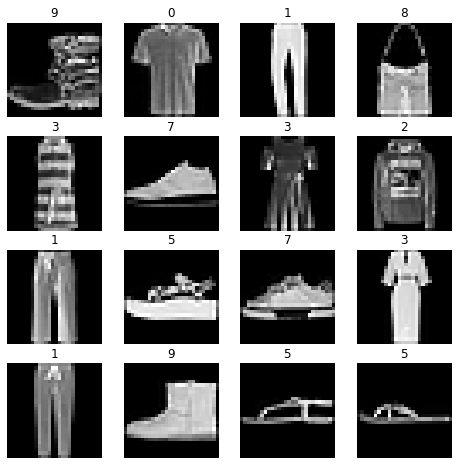

In [29]:
testset = get_loader(split="test",bs=1,nclass=N_CLASSES,augment=None)
top16 = itertools.islice(iter(testset),16)
fig,ax = plt.subplots(4,4)
fig.set_size_inches(8,8)
for i,(x,y) in enumerate(top16):
    ax.flat[i].imshow(x[0,0,...],cmap="gray")
    ax.flat[i].set_title(f"{torch.argmax(y[0]).numpy()}")
    ax.flat[i].axis("off")
plt.show()

In [30]:
acc,loss = val(
    testset,
    c4_cnn.cuda(),
    torch.nn.CrossEntropyLoss(),
    "cuda"
)
print(f"Test Acc:{acc*100:.2f}%     Test Loss:{loss:>7f}")

Test Acc:89.88%     Test Loss:0.446892


#### Testing on testset augmented with actions of C4

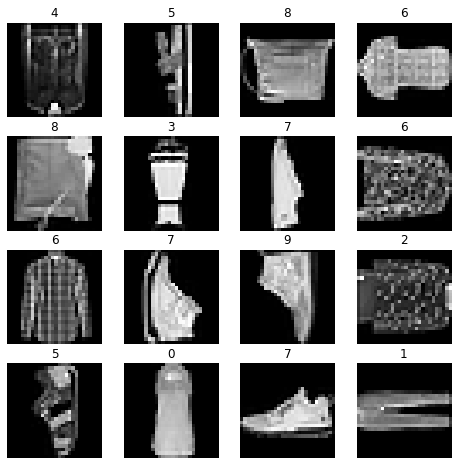

In [31]:
testset = get_loader(split="test",bs=1,nclass=N_CLASSES,augment="c4")
top16 = itertools.islice(iter(testset),16)
fig,ax = plt.subplots(4,4)
fig.set_size_inches(8,8)
for i,(x,y) in enumerate(top16):
    ax.flat[i].imshow(x[0,0,...],cmap="gray")
    ax.flat[i].set_title(f"{torch.argmax(y[0]).numpy()}")
    ax.flat[i].axis("off")
plt.show()

In [32]:
acc,loss = val(
    testset,
    c4_cnn.cuda(),
    torch.nn.CrossEntropyLoss(),
    "cuda"
)
print(f"Test Acc:{acc*100:.2f}%     Test Loss:{loss:>7f}")

Test Acc:79.12%     Test Loss:0.966638


#### Testing on testset augmented with actions of D4

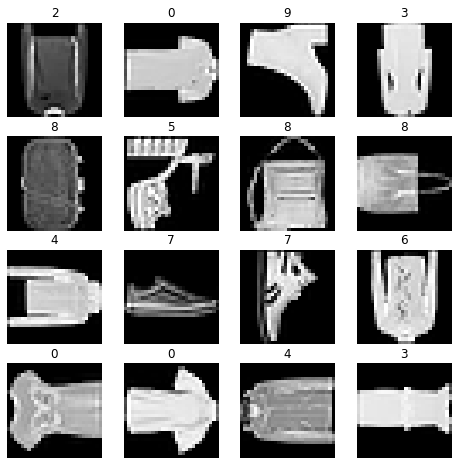

In [33]:
testset = get_loader(split="test",bs=1,nclass=N_CLASSES,augment="d4")
top16 = itertools.islice(iter(testset),16)
fig,ax = plt.subplots(4,4)
fig.set_size_inches(8,8)
for i,(x,y) in enumerate(top16):
    ax.flat[i].imshow(x[0,0,...],cmap="gray")
    ax.flat[i].set_title(f"{torch.argmax(y[0]).numpy()}")
    ax.flat[i].axis("off")
plt.show()

In [34]:
acc,loss = val(
    testset,
    c4_cnn.cuda(),
    torch.nn.CrossEntropyLoss(),
    "cuda"
)
print(f"Test Acc:{acc*100:.2f}%     Test Loss:{loss:>7f}")

Test Acc:72.21%     Test Loss:1.415062


### D4-CNN

In [35]:
# instantiate the model
N_CLASSES = 10
d4_cnn = EqSimpleCNN(DihedralGroup(4),8,N_CLASSES)
print(d4_cnn)

EqSimpleCNN(
  (c1): LiftingConvolution(
    (kernel): InterpolativeLiftingKernel(
      (group): DihedralGroup()
    )
  )
  (r1): ReLU()
  (p1): SpatialMaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c2): GroupConvolution(
    (kernel): InterpolativeGroupKernel(
      (group): DihedralGroup()
    )
  )
  (r2): ReLU()
  (p2): SpatialMaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): GroupConvolution(
    (kernel): InterpolativeGroupKernel(
      (group): DihedralGroup()
    )
  )
  (r3): ReLU()
  (gp): GlobalMaxPooling()
  (group_pooling): GroupMaxPool()
  (clf): Linear(in_features=128, out_features=10, bias=True)
)


In [36]:
print(f"Number of parameters: {count_params(d4_cnn)}")

Number of parameters: 738858


In [37]:
# load the trained weights
ret = d4_cnn.load_state_dict(torch.load("ckpt/D4SimpleCNN_FashionMNIST.pth"))
ret

<All keys matched successfully>

#### Testing on testset without augmentation

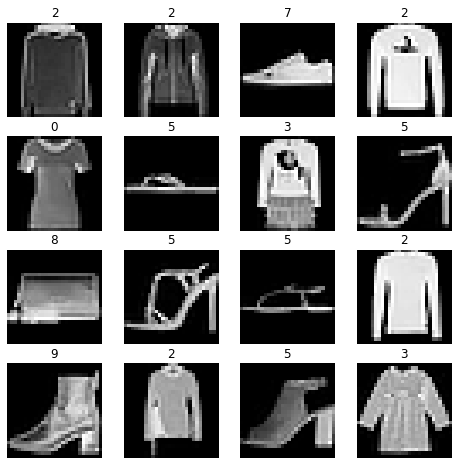

In [38]:
testset = get_loader(split="test",bs=1,nclass=N_CLASSES,augment=None)
top16 = itertools.islice(iter(testset),16)
fig,ax = plt.subplots(4,4)
fig.set_size_inches(8,8)
for i,(x,y) in enumerate(top16):
    ax.flat[i].imshow(x[0,0,...],cmap="gray")
    ax.flat[i].set_title(f"{torch.argmax(y[0]).numpy()}")
    ax.flat[i].axis("off")
plt.show()

In [39]:
acc,loss = val(
    testset,
    d4_cnn.cuda(),
    torch.nn.CrossEntropyLoss(),
    "cuda"
)
print(f"Test Acc:{acc*100:.2f}%     Test Loss:{loss:>7f}")

Test Acc:89.06%     Test Loss:0.445143


#### Testing on testset augmented with actions of C4

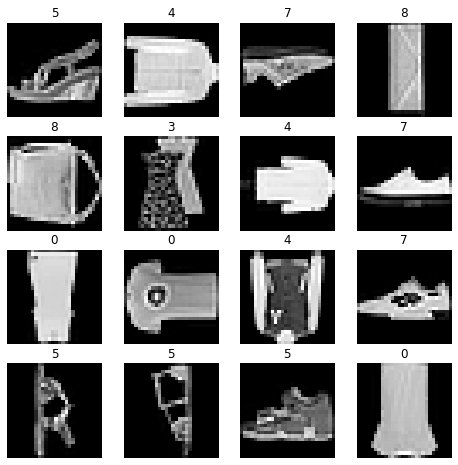

In [40]:
testset = get_loader(split="test",bs=1,nclass=N_CLASSES,augment="c4")
top16 = itertools.islice(iter(testset),16)
fig,ax = plt.subplots(4,4)
fig.set_size_inches(8,8)
for i,(x,y) in enumerate(top16):
    ax.flat[i].imshow(x[0,0,...],cmap="gray")
    ax.flat[i].set_title(f"{torch.argmax(y[0]).numpy()}")
    ax.flat[i].axis("off")
plt.show()

In [41]:
acc,loss = val(
    testset,
    d4_cnn.cuda(),
    torch.nn.CrossEntropyLoss(),
    "cuda"
)
print(f"Test Acc:{acc*100:.2f}%     Test Loss:{loss:>7f}")

Test Acc:84.16%     Test Loss:0.672201


#### Testing on testset augmented with actions of D4

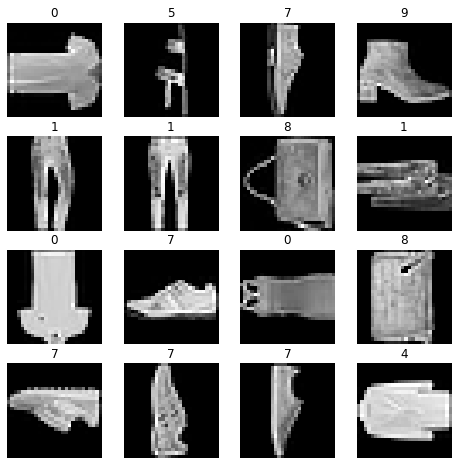

In [42]:
testset = get_loader(split="test",bs=1,nclass=N_CLASSES,augment="d4")
top16 = itertools.islice(iter(testset),16)
fig,ax = plt.subplots(4,4)
fig.set_size_inches(8,8)
for i,(x,y) in enumerate(top16):
    ax.flat[i].imshow(x[0,0,...],cmap="gray")
    ax.flat[i].set_title(f"{torch.argmax(y[0]).numpy()}")
    ax.flat[i].axis("off")
plt.show()

In [43]:
acc,loss = val(
    testset,
    d4_cnn.cuda(),
    torch.nn.CrossEntropyLoss(),
    "cuda"
)
print(f"Test Acc:{acc*100:.2f}%     Test Loss:{loss:>7f}")

Test Acc:83.45%     Test Loss:0.705305


|| Standard-CNN | C4-Invariant-CNN | D4-Invariant-CNN|
|---|---|---|---|
|No augmentation| 90.92% | 89.88%  | 89.06% |
| C4 augmentation| 32.39% | 79.12% | 84.16% |
| D4 augmentation | 31.55% | 72.21% | 83.45% |

## Conclusion
In this notebook we implemented a CNN that is invariat to the actions of the group D4, that is the group of symmetries of a square (90 degrees rotations and reflections along the four axis). We implemented also a CNN invariant only to the four rotations (a soubgroup of D4) to compare the performances. We then benchmarked the three networks: the standard convolutional neural network, the C4 invariant convolutional network and the D4 invariant convolutional network on the Fashion-MNIST dataset. From the results it emerges that the three networks reah almost the same accuracy on the testset without augmentation, but the situation changes drastically when we augment the testset applying actions from C4 and D4 to the images.

As expected the Standard-CNN fails to classify augmented images, the accuracy drops from 90% to about 30%. In the C4 Invariant CNN the accuracy drops only 10 points in the C4 augmented dataset and about 17 points on the D4 augmented dataset. The D4 invariants CNN reaches the best performances both in the C4 and D4 augmented datasets.

In particular we showed that it is possible to get good performances on augmented dataset without using augmentation in the training (the is the most used techniques to learn invariance) but generalizing the convolution to be equivariant to a larger symmetry group with respect to translation.

## Bibliography
- Cohen, Taco, and Max Welling. "Group equivariant convolutional networks." International conference on machine learning. PMLR, 2016.
- Goodfellow, Ian, Yoshua Bengio, and Aaron Courville. Deep learning. MIT press, 2016.
